In [17]:
import os
import sys
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
import numpy as np
import einops
import wandb
import plotly.express as px
from pathlib import Path
import itertools
import random
from IPython.display import display
import wandb
from jaxtyping import Float, Int, Bool, Shaped, jaxtyped
from typing import Union, Optional, Tuple, Callable, Dict
import typeguard
from functools import partial
import copy
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
import pandas as pd
import torch
import matplotlib.pyplot as plt

import circuits.eval_sae_as_classifier as eval_sae
import circuits.analysis as analysis
import circuits.eval_board_reconstruction as eval_board_reconstruction
import circuits.get_eval_results as get_eval_results
import circuits.f1_analysis as f1_analysis
import circuits.utils as utils
import circuits.pipeline_config as pipeline_config
from circuits.dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, AutoEncoderNew

# Make sure exercises are in the path
chapter = r"chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part53_othellogpt"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

extract_dir = '/root/ARENA_3.0/chapter1_transformer_interp/exercises/extracted_files'
sys.path.append(extract_dir)
sys.path.append("/root/miniconda3/envs/arena-env/lib/python3.11/site-packages")
from huggingface_hub import hf_hub_download
import chess_utils
#from plotly_utils import imshow
#from neel_plotly import scatter, line

MAIN = __name__ == "__main__"

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
import pickle
with open('meta.pkl', 'rb') as picklefile:
    meta = pickle.load(picklefile)


In [18]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformer_lens import HookedTransformer

model = AutoModelForCausalLM.from_pretrained("adamkarvonen/8LayerChessGPT2")
model.to(device)

# Path to the model file (adjust the file name as needed)
autoencoder_group_path = Path("/root/chessgpt_git/chessgpt_git/SAE_BoardGameEval/autoencoders/testing_chess/")
autoencoder_path = Path("/root/chessgpt_git/chessgpt_git/SAE_BoardGameEval/autoencoders/testing_chess/trainer4/ae.pt")

# Load the model weights (assuming the model definition is available)
autoencoder = torch.load(autoencoder_path)

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
train_dataset_name = f"chess_train_dataset_check_10k.pkl"

if os.path.exists(train_dataset_name):
    print("Loading statistics aggregation dataset")
    with open(train_dataset_name, "rb") as f:
        train_data = pickle.load(f)
else:
    train_data = eval_sae.construct_dataset(
        False,
        [chess_utils.board_to_check_state],
        10000,
        split="train",
        device=device,
        precompute_dataset=True,
    )
    with open(train_dataset_name, "wb") as f:
        pickle.dump(train_data, f)
sae = AutoEncoder.from_pretrained(Path(autoencoder_path), device=device)

100%|██████████| 10000/10000 [00:15<00:00, 640.27it/s]


board_to_check_state
Element size: 1 bytes
Number of elements: 2560000
Memory usage: 2.44140625 MB


In [20]:
games_close_to_check = []

for i, pgn in enumerate(train_data['decoded_inputs']):
    for j in range(len(pgn)):
        if pgn[j] == '+':
            games_close_to_check.append((i, j))

print(len(games_close_to_check))
print(games_close_to_check[0])
print(train_data['decoded_inputs'][games_close_to_check[0][0]][games_close_to_check[0][1]])

train_data['board_to_check_state'].nonzero()[:20]



12291
(3, 71)
+


tensor([[  3,  72,   0,   0,   0],
        [  3,  73,   0,   0,   0],
        [  3,  74,   0,   0,   0],
        [  3,  75,   0,   0,   0],
        [  4, 199,   0,   0,   0],
        [  4, 200,   0,   0,   0],
        [  4, 201,   0,   0,   0],
        [  4, 202,   0,   0,   0],
        [  4, 203,   0,   0,   0],
        [  4, 204,   0,   0,   0],
        [  4, 205,   0,   0,   0],
        [  4, 235,   0,   0,   0],
        [  4, 236,   0,   0,   0],
        [  4, 237,   0,   0,   0],
        [  4, 238,   0,   0,   0],
        [  4, 239,   0,   0,   0],
        [  4, 240,   0,   0,   0],
        [  4, 241,   0,   0,   0],
        [  7,  20,   0,   0,   0],
        [  7,  21,   0,   0,   0]], device='cuda:0')

In [21]:
train_data.keys()
train_data['encoded_inputs'][0]


[15,
 6,
 4,
 25,
 9,
 0,
 19,
 28,
 11,
 0,
 7,
 4,
 19,
 25,
 8,
 0,
 25,
 10,
 0,
 8,
 4,
 26,
 9,
 0,
 27,
 11,
 0,
 9,
 4,
 26,
 10,
 0,
 26,
 11,
 0,
 10,
 4,
 27,
 9,
 0,
 27,
 31,
 26,
 10,
 0,
 11,
 4,
 27,
 31,
 26,
 10,
 0,
 17,
 27,
 12,
 0,
 12,
 4,
 17,
 28,
 9,
 0,
 20,
 3,
 20,
 0,
 13,
 4,
 17,
 27,
 7,
 0,
 23,
 11,
 0,
 14,
 4,
 19,
 28,
 8,
 0,
 17,
 26,
 12,
 0,
 6,
 5,
 4,
 20,
 3,
 20,
 0,
 22,
 27,
 13,
 0,
 6,
 6,
 4,
 30,
 8,
 0,
 17,
 28,
 10,
 0,
 6,
 7,
 4,
 17,
 30,
 7,
 0,
 17,
 28,
 13,
 0,
 6,
 8,
 4,
 17,
 26,
 8,
 0,
 17,
 29,
 11,
 0,
 6,
 9,
 4,
 17,
 31,
 29,
 11,
 0,
 30,
 31,
 29,
 11,
 0,
 6,
 10,
 4,
 22,
 27,
 6,
 0,
 19,
 24,
 26,
 12,
 0,
 6,
 11,
 4,
 21,
 26,
 8,
 0,
 21,
 25,
 12,
 0,
 6,
 12,
 4,
 24,
 8,
 0,
 19,
 30,
 10,
 0,
 6,
 13,
 4,
 29,
 9,
 0,
 19,
 30,
 28,
 11,
 0,
 6,
 14,
 4,
 18,
 29,
 7,
 0,
 19,
 30,
 12,
 0,
 7,
 5,
 4,
 23,
 9,
 0,
 22,
 27,
 12,
 0,
 7,
 6,
 4,
 22,
 31,
 27,
 12,
 0,
 17,
 31,
 27,
 12,
 0,
 7,
 7,
 

In [22]:

model_activations = []
def get_activation(name):
    def hook(model, input, output):
        model_activations.append(output)
    return hook
activation_handle = model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}"))
activation_handle.remove()

[167, 228, 410, 614, 706, 746, 765, 1218, 1396, 1610, 1673, 1810, 1858, 1878, 1969, 2048, 2252, 2303, 2381, 2388, 2533, 2595, 2794, 2960, 3133, 3168, 3240, 3517, 3814, 3911]


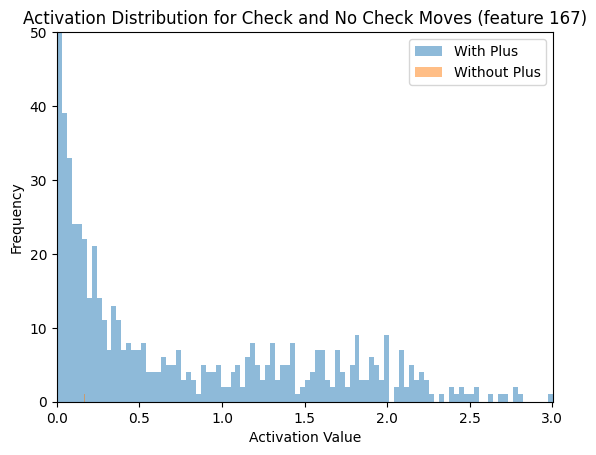

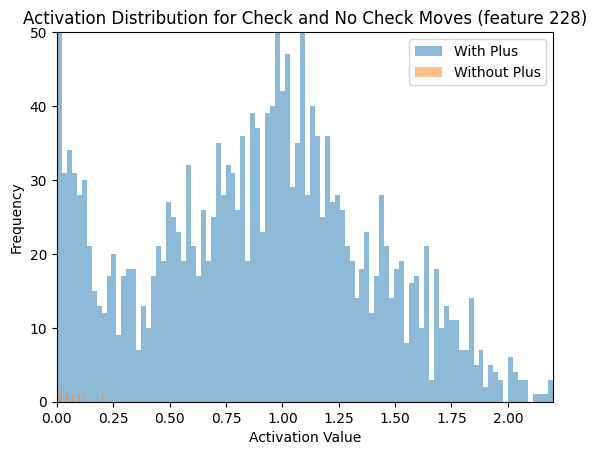

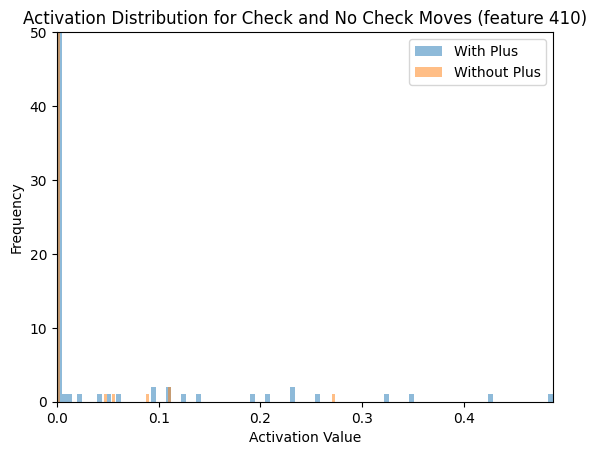

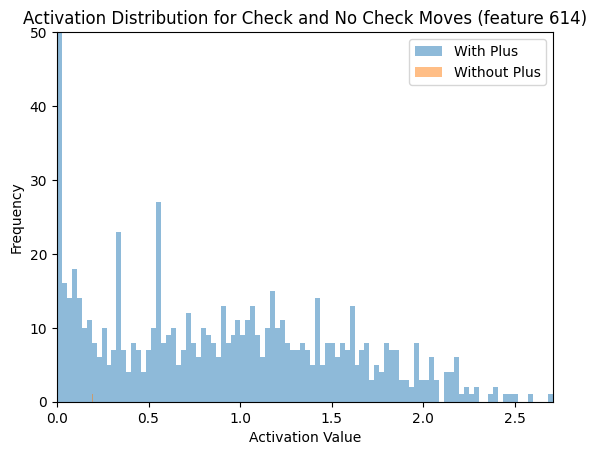

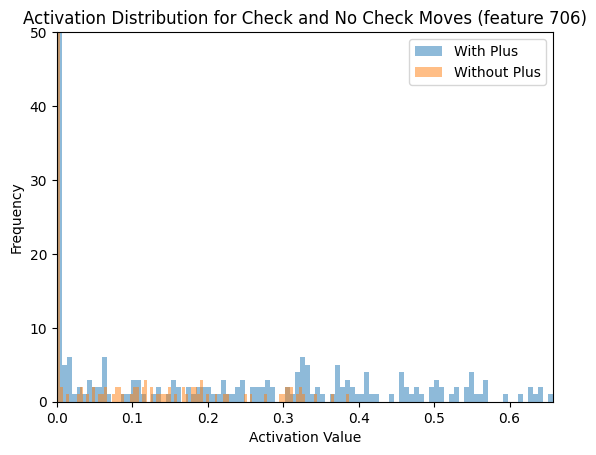

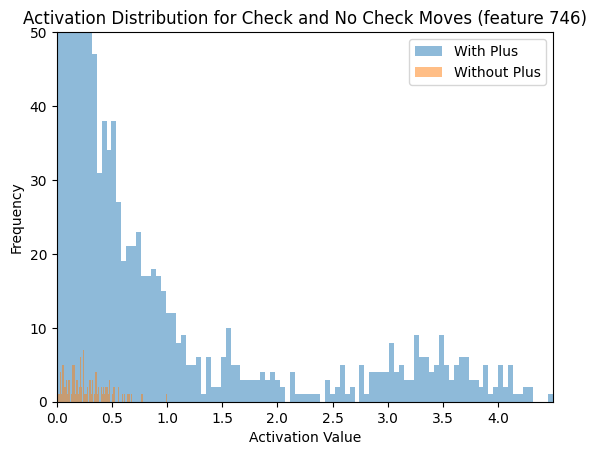

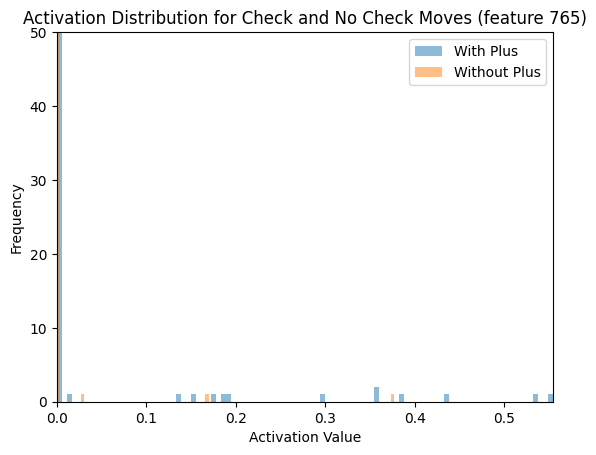

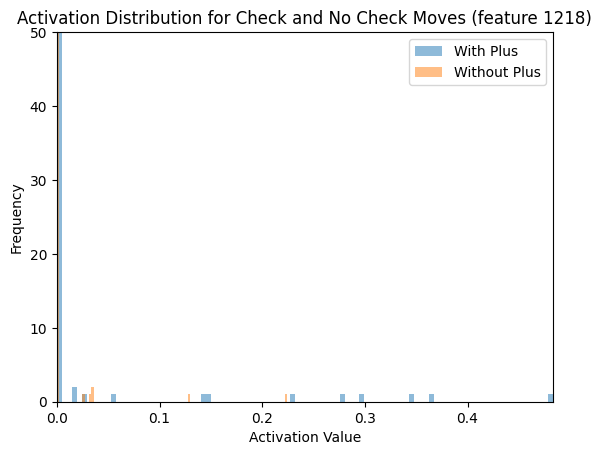

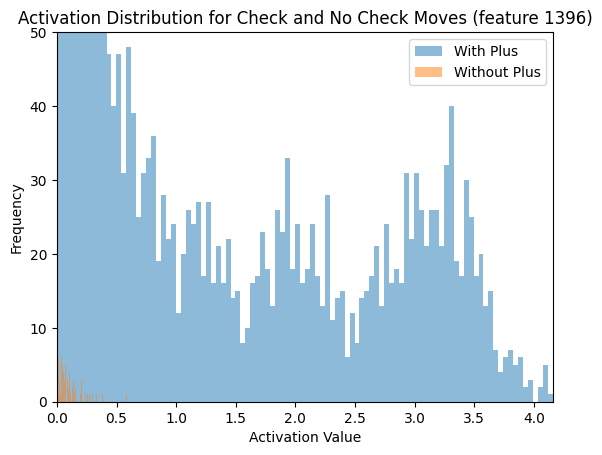

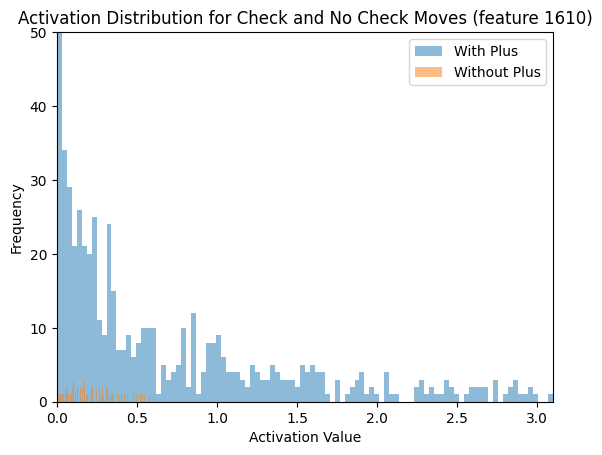

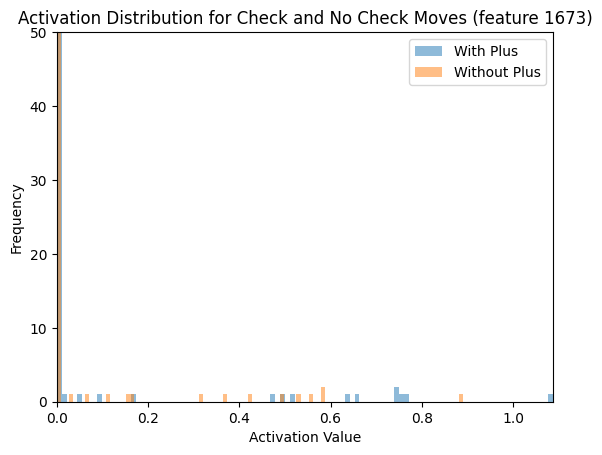

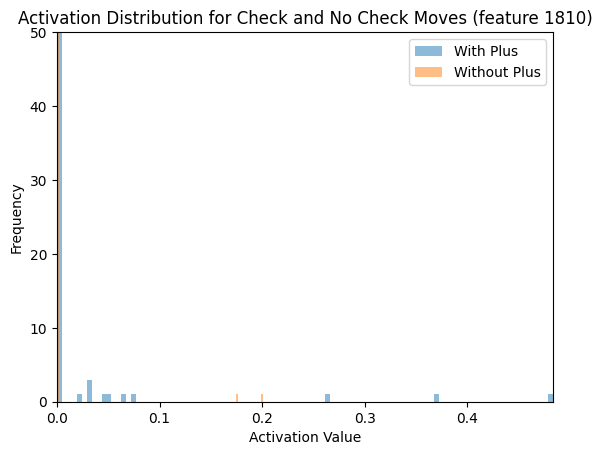

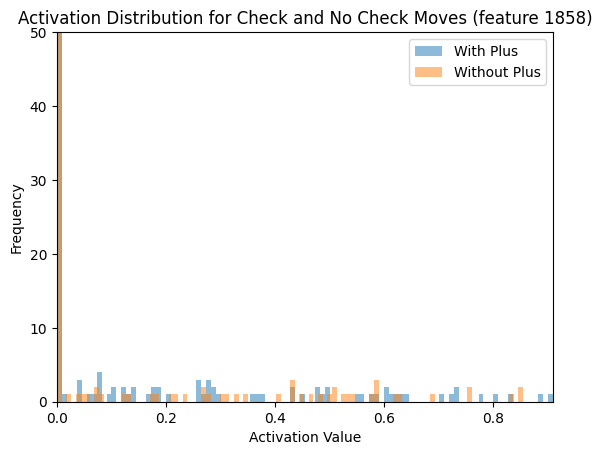

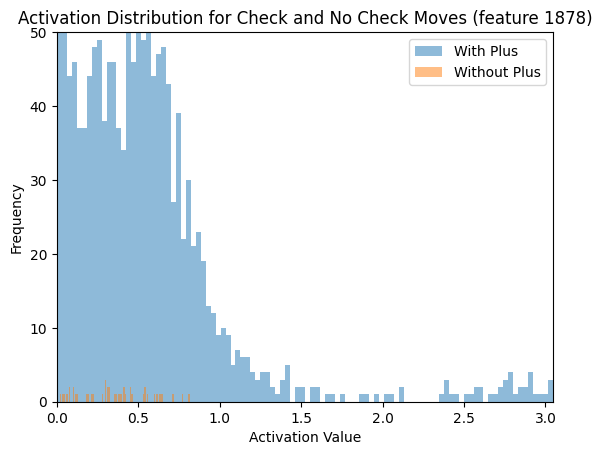

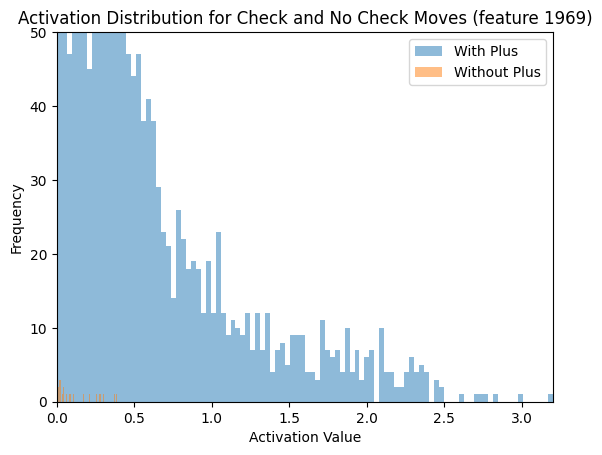

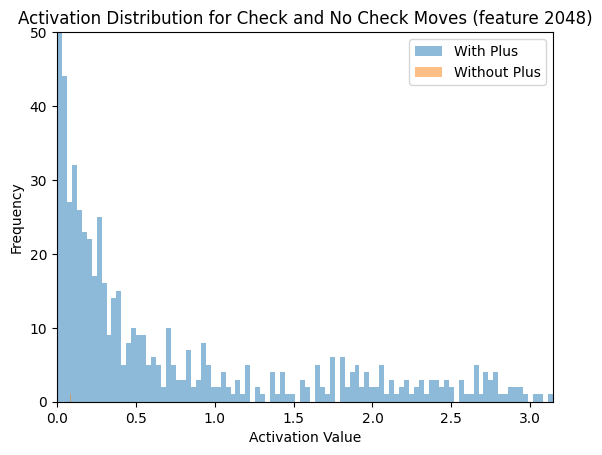

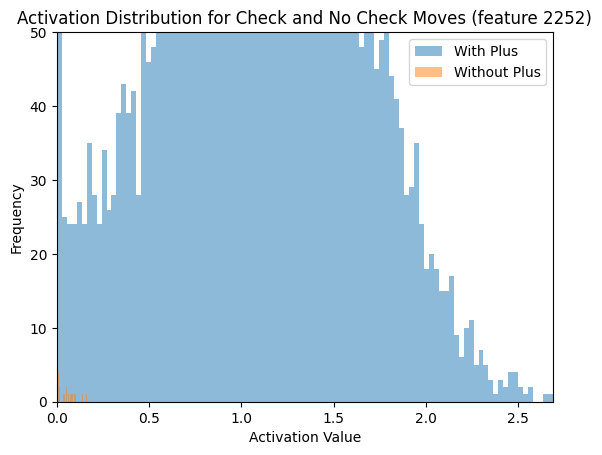

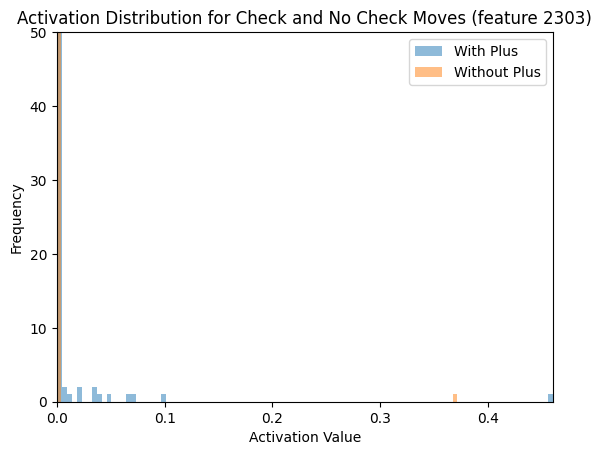

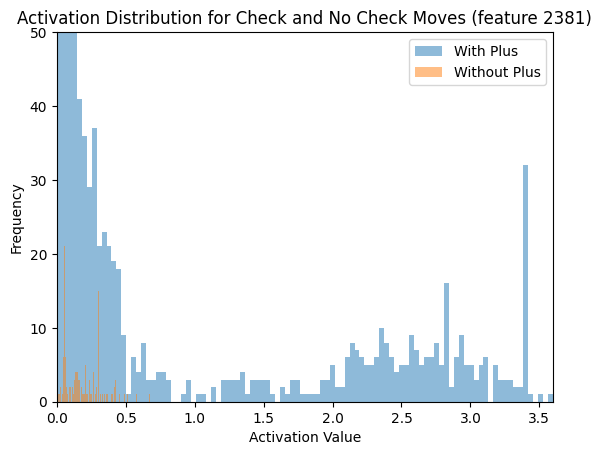

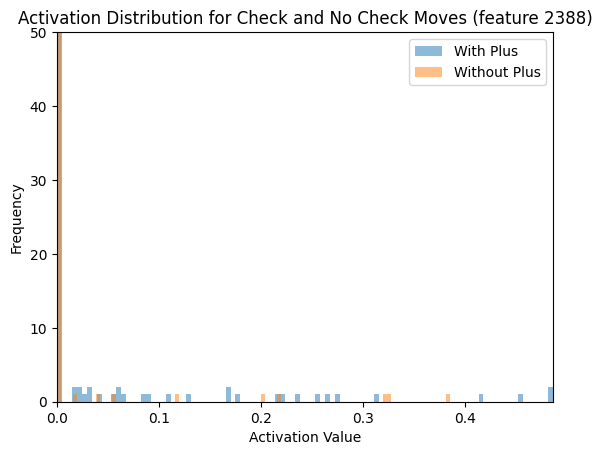

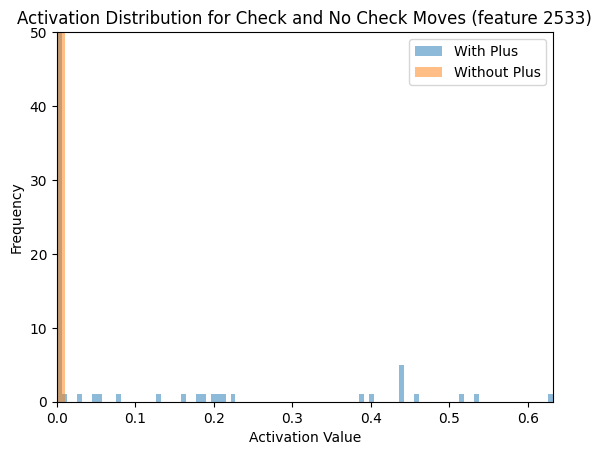

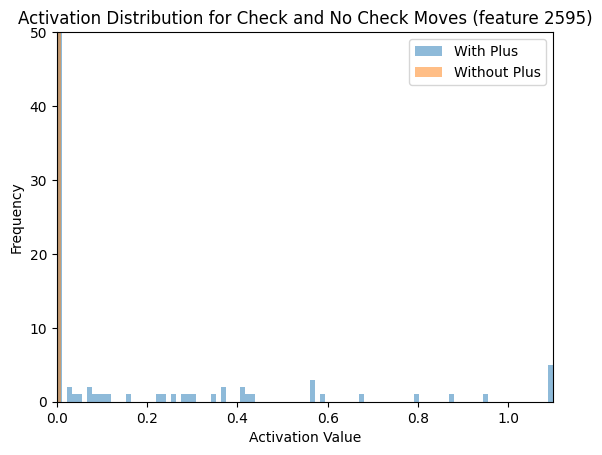

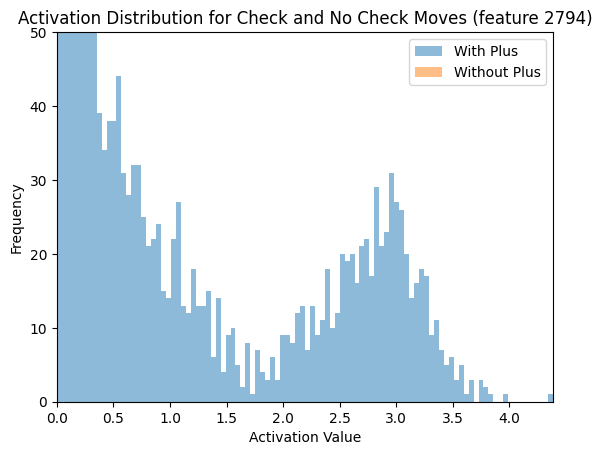

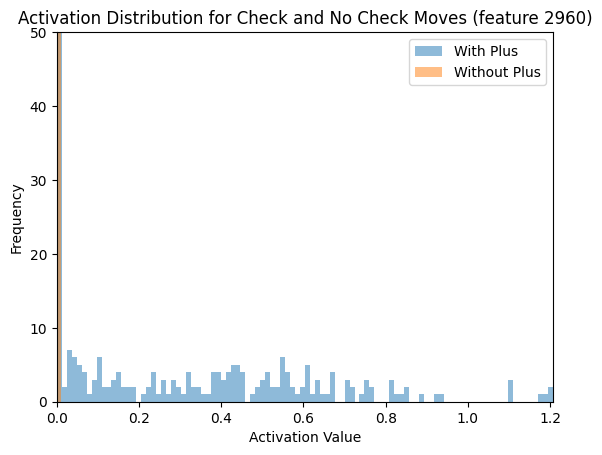

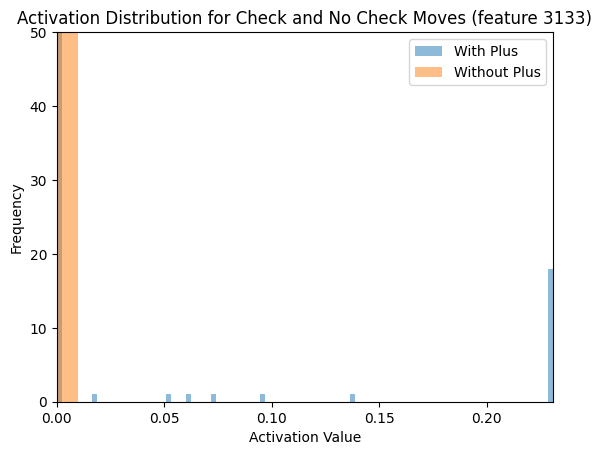

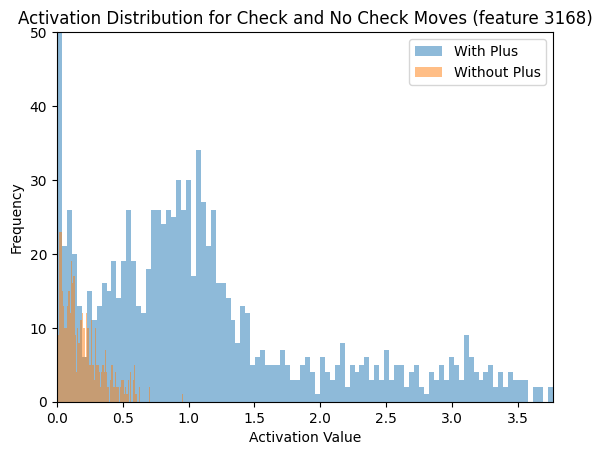

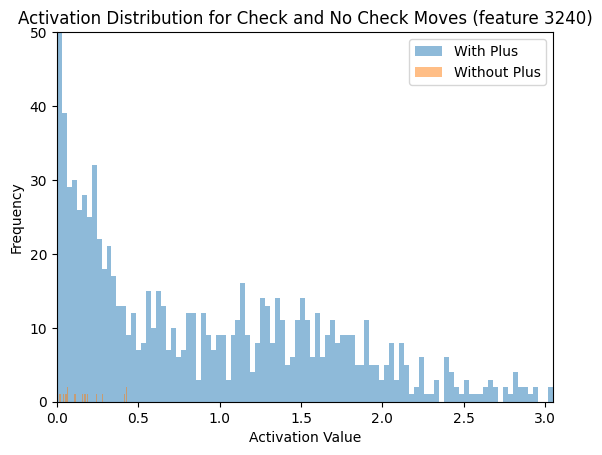

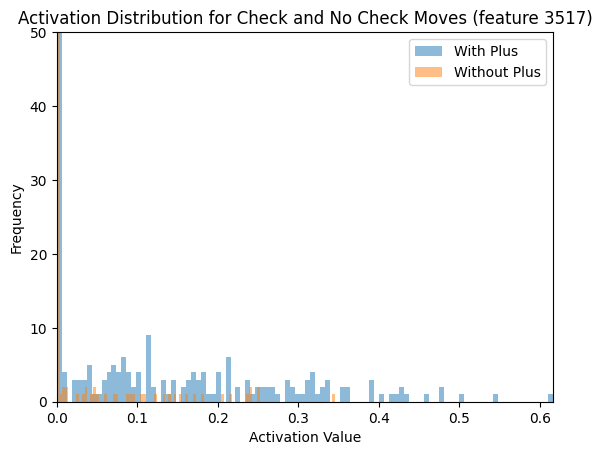

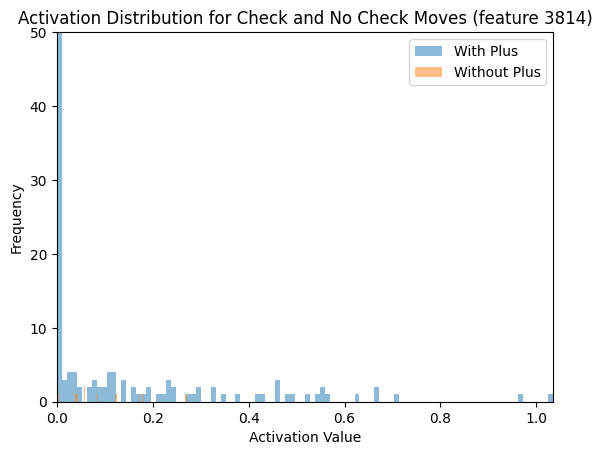

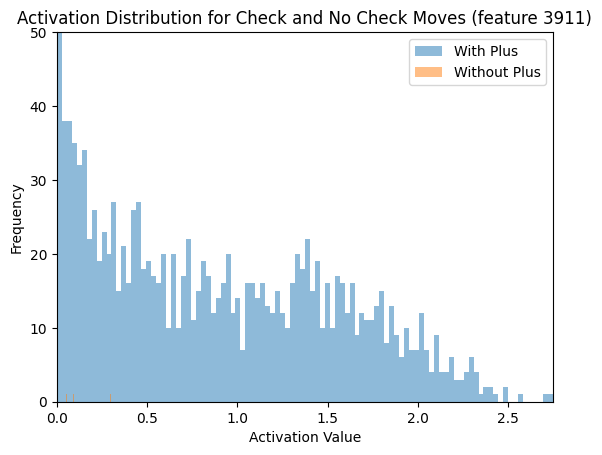

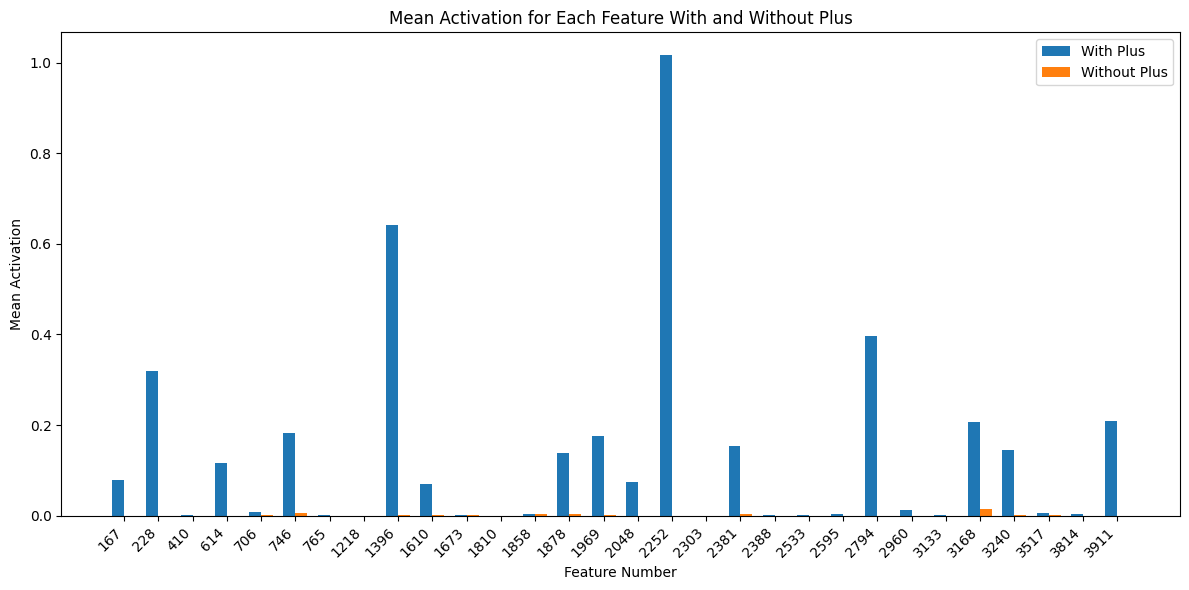

In [36]:
t.set_grad_enabled(False)
from copy import copy
from collections import defaultdict
import common
def find_last_ocurrence(arr, value):
    for i in range(-1, -len(arr), -1):
        if arr[i]==value:
            return i
    raise Exception
#feature_numbers=[167, 228, 410, 614, 706]
agg_results=common.get_aggregation_results(1000)
formatted_results=common.get_formatted_results(agg_results)
feature_numbers=common.get_true_feature_indices(formatted_results, 'board_to_check_state').tolist()
print(feature_numbers)
num_samples = 10000

pgn_index_list = t.randint(10, 1000, (num_samples,))
move_index_list = t.randint(10, 256, (num_samples,))
yes_plus_feature_activations = defaultdict(list)
no_plus_feature_activations = defaultdict(list)
max_activations = defaultdict(int)
# for pgn_idx, move_idx in zip(pgn_index_list, move_index_list):
#     encoded_input = train_data['encoded_inputs'][pgn_idx][:move_idx]
#     activation_handle=model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}"))
#     model(t.tensor(encoded_input).to(device)).logits[-1]
#     activation_handle.remove()
#     chess_gpt_activations = model_activations[0][0][0][-1]
#     model_activations = []
#     sae_activations = sae.encode(chess_gpt_activations)
#     this_feature_activation = sae_activations[feature_number].cpu().numpy() 
#     max_activation = max(max_activation, this_feature_activation)
#     if train_data['board_to_check_state'][pgn_idx, move_idx, 0, 0, 0] == 0:
#         not_check_activations.append(this_feature_activation)
#     else:
#         yes_check_activations.append(this_feature_activation)
num_sampled=0
num_available=train_data['board_to_check_state'].nonzero().shape[0]
current_sample=0
while num_sampled<num_samples and current_sample<num_available:
    pgn_idx, move_idx, _, _, _ = train_data['board_to_check_state'].nonzero()[current_sample]
    current_sample+=1
    if move_idx==0 or not 4==train_data['encoded_inputs'][pgn_idx][move_idx-1]:
        continue
    num_sampled+=1
    encoded_input = train_data['encoded_inputs'][pgn_idx][:move_idx]
    encoded_input_without_plus = copy(train_data['encoded_inputs'][pgn_idx][:move_idx])
    del encoded_input_without_plus[find_last_ocurrence(encoded_input_without_plus, 2)]
    assert len(encoded_input)-1==len(encoded_input_without_plus)
    activation_handle=model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}"))

    model(t.tensor(encoded_input).to(device)).logits[-1]
    chess_gpt_activations = model_activations[0][0][0][-1]
    model_activations = []
    sae_activations = sae.encode(chess_gpt_activations)
    for feature_number in feature_numbers:
        this_feature_activation = sae_activations[feature_number].cpu().numpy() 
        max_activations[feature_number] = max(max_activations[feature_number], this_feature_activation)
        yes_plus_feature_activations[feature_number].append(this_feature_activation.item())

    model(t.tensor(encoded_input_without_plus).to(device)).logits[-1]
    chess_gpt_activations = model_activations[0][0][0][-1]
    model_activations = []
    sae_activations = sae.encode(chess_gpt_activations)
    for feature_number in feature_numbers:
        this_feature_activation = sae_activations[feature_number].cpu().numpy() 
        max_activations[feature_number] = max(max_activations[feature_number], this_feature_activation)
        no_plus_feature_activations[feature_number].append(this_feature_activation.item())



    activation_handle.remove()

    

multiplier = 0.2
for feature_number in feature_numbers:
    yes_plus_activations, no_plus_activations = yes_plus_feature_activations[feature_number], no_plus_feature_activations[feature_number]
    plt.hist(yes_plus_activations, bins=100, alpha=0.5, label='With Plus')
    plt.hist(no_plus_activations, bins=100, alpha=0.5, label='Without Plus')
    plt.xlim(0, max_activations[feature_number])
    plt.ylim(0, 50)
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.title(f'Activation Distribution for Check and No Check Moves (feature {feature_number})')
    plt.legend(loc='upper right')
    plt.show()


# Calculate mean values for each feature
mean_yes_plus = [np.mean(yes_plus_feature_activations[feature]) for feature in feature_numbers]
mean_no_plus = [np.mean(no_plus_feature_activations[feature]) for feature in feature_numbers]

# Set up the bar chart
x = np.arange(len(feature_numbers))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, mean_yes_plus, width, label='With Plus')
rects2 = ax.bar(x + width/2, mean_no_plus, width, label='Without Plus')

# Add labels and title
ax.set_ylabel('Mean Activation')
ax.set_xlabel('Feature Number')
ax.set_title('Mean Activation for Each Feature With and Without Plus')
ax.set_xticks(x)
ax.set_xticklabels(feature_numbers)
ax.legend()

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()







In [42]:
alternate_mean_yes_plus=[0.0773756206035614,
 0.3330446183681488,
 0.0006466065533459187,
 0.11414089798927307,
 0.006150310859084129,
 0.19969335198402405,
 0.0007380128954537213,
 0.0006392025970853865,
 0.6554531455039978,
 0.0760856419801712,
 0.0007011459674686193,
 0.00043940055184066296,
 0.004761904943734407,
 0.1262831687927246,
 0.17908886075019836,
 0.06277710199356079,
 1.0122697353363037,
 0.0002467706217430532,
 0.16270574927330017,
 0.0011228565126657486,
 0.0013402235927060246,
 0.0036979455035179853,
 0.39626261591911316,
 0.011182558722794056,
 0.0007832019473426044,
 0.20828862488269806,
 0.141825333237648,
 0.0046489606611430645,
 0.0030788907315582037,
 0.2152484655380249]

In [48]:
[abs(mean_yes_plus[i]-alternate_mean_yes_plus[i])/mean_yes_plus[i] for i in range(30)]

[0.01596970359323462,
 0.04603368177278343,
 0.027709654899110665,
 0.018345941748181067,
 0.26721019523821665,
 0.0920822732612359,
 0.10596059341270479,
 0.506128076129352,
 0.021711964594939327,
 0.08843057553330512,
 0.4503104208023924,
 0.6856352081331101,
 0.15351430879000877,
 0.08307443663466532,
 0.011899095085089165,
 0.1496304306356285,
 0.0036175300866378123,
 0.525730593831986,
 0.05515822390321319,
 0.2701960815633891,
 0.10931503414603089,
 0.285973302720001,
 0.0025365063797497863,
 0.15175476550409264,
 0.034553213444529704,
 0.008246205119572105,
 0.02220397255954261,
 0.08694831951681885,
 0.046841542805651074,
 0.025797995852831535]

In [ ]:


total_yeses_over_activation = len([x for x in yes_check_activations if x > max_activation * multiplier]) 
total_nos_over_activation = len([x for x in not_check_activations if x > max_activation * multiplier]) 

print(total_yeses_over_activation/(total_yeses_over_activation + total_nos_over_activation))
print(total_yeses_over_activation, total_nos_over_activation)


0.5138461538461538
167 158


In [ ]:
p_act_yes = total_yeses_over_activation/len(yes_check_activations)
p_yes = len(train_data['board_to_check_state'].nonzero())/len(train_data['board_to_check_state'].flatten())

p_act_no = total_nos_over_activation/len(not_check_activations)
p_no = 1 - p_yes

p_act = p_act_yes * p_yes + p_act_no * p_no

p_yes_act = p_act_yes * p_yes / p_act
print("p_act_yes: ", round(p_act_yes, 3), "p_yes: ", round(p_yes, 3), "p_act_no: ", round(p_act_no, 3), "p_no: ", round(p_no, 3), "p_act: ", round(p_act, 3), "p_yes_act: ", round(p_yes_act, 3))

p_act_yes:  0.081 p_yes:  0.026 p_act_no:  0.081 p_no:  0.974 p_act:  0.081 p_yes_act:  0.026


In [ ]:
train_data['board_to_check_state'].nonzero()[:10]

tensor([[  3,  72,   0,   0,   0],
        [  3,  73,   0,   0,   0],
        [  3,  74,   0,   0,   0],
        [  3,  75,   0,   0,   0],
        [  4, 199,   0,   0,   0],
        [  4, 200,   0,   0,   0],
        [  4, 201,   0,   0,   0],
        [  4, 202,   0,   0,   0],
        [  4, 203,   0,   0,   0],
        [  4, 204,   0,   0,   0]], device='cuda:0')